<img src="https://storage.googleapis.com/handsome-draculax/logo.png" width="200px">


**LEGACY MLOps1**

written by: Raihansyah A.

distributed to: Machine Learning team members of CH2-PS344

content:
*   Google Cloud authentication
*   First stage data preprocessing

documentation:
https://storage.googleapis.com/handsome-dracula/documentation/premldocs.pdf

# Section 1: Libraries

In [ ]:
!pip install opencv-python
!pip install dlib

In [ ]:
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import gc
import json
import os
import bz2
import cv2
import dlib
import shutil
from google.colab.patches import cv2_imshow
from zipfile import ZipFile

# Section 2: Dataset Retrieving

#### <font color="blue">Google Colab Authentication</font>: To authenticate this Colab owner.

In [ ]:
from google.colab import auth
auth.authenticate_user()

#### <font color="blue">Install Cloud SDK</font>: To enable gcloud command in Colab.

To install Cloud SDK

In [ ]:
!curl https://sdk.cloud.google.com | bash

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/surface/sql/ssl_certs/delete.py
google-cloud-sdk/lib/surface/sql/ssl_certs/describe.py
google-cloud-sdk/lib/surface/sql/ssl_certs/list.py
google-cloud-sdk/lib/surface/sql/tiers/__init__.py
google-cloud-sdk/lib/surface/sql/tiers/list.py
google-cloud-sdk/lib/surface/sql/users/__init__.py
google-cloud-sdk/lib/surface/sql/users/create.py
google-cloud-sdk/lib/surface/sql/users/delete.py
google-cloud-sdk/lib/surface/sql/users/describe.py
google-cloud-sdk/lib/surface/sql/users/list.py
google-cloud-sdk/lib/surface/sql/users/set_password.py
google-cloud-sdk/lib/surface/sql/users/set_password_policy.py
google-cloud-sdk/lib/surface/storage/__init__.py
google-cloud-sdk/lib/surface/storage/buckets/__init__.py
google-cloud-sdk/lib/surface/storage/buckets/add_iam_policy_binding.py
google-cloud-sdk/lib/surface/storage/buckets/anywhere_caches/__init__.py
google-cloud-sdk/lib/surface/storage/buckets/anywhere_caches/create.py
google-

To authenticate user account and project id

In [ ]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  n



#### <font color="blue">Connect to Cloud Storage</font>: To retrieve the required files.

In [ ]:
__stage1_dir = 'stage1-dir'
try:
  os.mkdir(__stage1_dir)
except:
  pass

In [ ]:
!gsutil -m cp gs://count-dracula/celeba-raw.zip $__stage1_dir
!gsutil cp gs://count-dracula/labels.txt $__stage1_dir
!gsutil cp gs://count-dracula/list_attr_celeba.txt $__stage1_dir
!gsutil cp gs://count-dracula/list_landmarks_align_celeba.txt $__stage1_dir
!gsutil -m cp gs://count-dracula/shape_predictor_68_face_landmarks.dat.bz2 .
with bz2.open('shape_predictor_68_face_landmarks.dat.' + 'bz2', 'rb') as bz2obj:
  bz2data = bz2obj.read()
  with open('shape_predictor_68_face_landmarks.dat', 'wb') as f:
    f.write(bz2data)

Copying gs://count-dracula/celeba-raw.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1/1 files][  1.3 GiB/  1.3 GiB] 100% Done  40.9 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.3 GiB.                                      
Copying gs://count-dracula/labels.txt...
- [1 files][  3.3 MiB/  3.3 MiB]                                                
Operation completed over 1 objects/3.3 MiB.                                      
Copying gs://count-dracula/list_attr_celeba.txt...
- [1 files][ 23.8 MiB/ 23.8 MiB]                                                
Operation completed over 1 objects/23.8 MiB.                                     
Copying gs://count-dracula/list_landmarks_align_celeba.txt...
- [1 files][  9.5 MiB/  9.5 MiB]                                   

# Section 3: Data Preprocessing

#### Step 1: To build a function to filter images

In [ ]:
'''
 The following lines of codes are to selectively pick images of identities
 without having bangs, eyeglasses on, and any kind of hats on.
'''

def getSelectedIdentities(__numSampleEach):
  data = pd.read_csv(f'{__stage1_dir}/list_attr_celeba.txt', sep=' ')
  dataFramed = pd.DataFrame()
  identity = pd.read_csv(f'{__stage1_dir}/labels.txt', sep=' ', names=['Filename', 'Identity'])
  dataFramed['Identity'] = identity['Identity']
  dataFramed[data.columns] = pd.DataFrame(data)
  dataFramed = dataFramed[
      (dataFramed['Eyeglasses'] == -1) &
      (dataFramed['Bangs'] == -1) &
      (dataFramed['Wearing_Hat'] == -1) &
      (dataFramed['Smiling'] == -1) &
      (dataFramed['Mouth_Slightly_Open'] == -1) &
      (dataFramed['Attractive'] == 1)
    ]
  display(dataFramed)

  # The following lines of codes are to keep identities that have over six samples
  selectedIdentities = {}
  for i in range(dataFramed['Identity'].min(), dataFramed['Identity'].max() + 1):
    dataFramedSpecific = dataFramed[dataFramed['Identity'] == i]
    if len(dataFramedSpecific) >= __numSampleEach:
      selectedIdentities[i] = list(dataFramedSpecific['Img'])[:__numSampleEach]
  return selectedIdentities, __numSampleEach

#### Step 2: To extract CELEBA.zip

In [ ]:
with ZipFile(f'{__stage1_dir}/celeba-raw.zip', 'r') as zipObj:
    zipObj.extractall(path=f"{__stage1_dir}/celeba-raw")

#### Step 3: To write our preprocessed dataset checkpoint

In [ ]:
def displayValidate(__selectedIdentities, __numSampleEach):
  __target = f'{__stage1_dir}/celeba-raw/img_align_celeba'
  randomSample = np.random.choice(list(__selectedIdentities.keys()), size=8, replace=False)
  f, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
  for i in range(0, 2):
    for j in range(0, 4):
      k = i*4+j
      randomIndices = np.random.choice([i for i in range(0, __numSampleEach)], size=2, replace=False)
      image0 = tf.keras.utils.load_img(f'{__target}/{__selectedIdentities[randomSample[k]][randomIndices[0]]}')
      image1 = tf.keras.utils.load_img(f'{__target}/{__selectedIdentities[randomSample[k]][randomIndices[1]]}')
      imageTensor0 = tf.keras.utils.img_to_array(image0) / 255.0
      imageTensor1 = tf.keras.utils.img_to_array(image1) / 255.0
      ax[i, j].imshow(tf.concat([imageTensor0, imageTensor1], axis=1))
      ax[i, j].set_title(f'Identity: {randomSample[k]}')
      ax[i, j].get_yaxis().set_visible(False)
      ax[i, j].set_xticks([178*x+89 for x in range(0,2)],
                ['Image 1', 'Image 2'])

  f.tight_layout()

In [ ]:
'''
  writeSelectedImgSeries(__take, __series_name):
    -> A function to generate a zip file saved in the cloud of a certain
    variety of the dataset
    -> __take: an integer, how many images per identity
    -> __series_name: a string, a variety name
'''

#!/bin/bash
def writeSelectedImgSeries(__take, __series_name, __selectedIdentities):
  jsonData = {}
  __celebaImages = f'{__stage1_dir}/celeba-raw/img_align_celeba'
  __selectedCeleba = f'{__stage1_dir}/celeba-selected-{__series_name}'
  __detect_face = dlib.get_frontal_face_detector()
  __detect_shape = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
  !rm -rf "$(echo $__selectedCeleba)"

  try:
    os.mkdir(__selectedCeleba)
  except:
    pass

  datasetReport = []
  for i in __selectedIdentities.keys():
    _pass = 0

    for j in range(0, __take):
      try:
        greyedFace = cv2.cvtColor(
          cv2.imread(f'{__celebaImages}/{__selectedIdentities[i][_pass]}'),
          cv2.COLOR_BGR2GRAY
        )
        points = __detect_shape(
          greyedFace,
          __detect_face(greyedFace)[0]
        )
        _pass += 1
      except:
        continue
      shutil.copy2(
        f'{__celebaImages}/{__selectedIdentities[i][_pass - 1]}',
        f'{__selectedCeleba}/{i}-{_pass - 1}.jpg'
      )
      pointXs = []
      pointYs = []
      for k in range(0, 68):
        pointXs.append(points.part(k).x)
        pointYs.append(points.part(k).y)
      jsonData[f'{i}-{j}'] = {'x': pointXs, 'y': pointYs}
    datasetReport.append([i, _pass])
  datasetReport = pd.DataFrame(datasetReport, columns=['Identity', 'Frequency'])

  def finalizeWrite():
    deprecated = datasetReport[datasetReport['Frequency'] < 4]
    deprIdentities = list(deprecated['Identity'])
    deprFrequencies = list(deprecated['Frequency'])
    for j, di in enumerate(deprIdentities):
      for df in range(0, deprFrequencies[j]):
        os.remove(f'{__selectedCeleba}/{di}-{df}.jpg')
        del jsonData[f'{di}-{df}']

    shutil.make_archive(__selectedCeleba, 'zip', __selectedCeleba)
    with open(f'{__selectedCeleba}.json', "w") as f:
      json.dump(jsonData, f)

    !gsutil -m cp "$(echo $__selectedCeleba).zip" "gs://count-dracula/selected-dataset"
    !gsutil -m cp "$(echo $__selectedCeleba).json" "gs://count-dracula/selected-dataset"

    !rm -rf "$(echo $__selectedCeleba)"
    return 1

  return finalizeWrite, datasetReport

In [ ]:
__nSame = 4
selectedIdentities, n = getSelectedIdentities(__nSame)
print(f'Total images to be saved: {__nSame * len(selectedIdentities)} across \
{len(selectedIdentities)} identities')

,Identity,Img,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
3,5805,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,9295,000005.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
6,9040,000007.jpg,1,-1,1,1,-1,-1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
9,612,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1
18,2929,000019.jpg,-1,1,1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202571,5260,202572.jpg,-1,1,1,-1,-1,-1,-1,1,...,-1,-1,-1,1,1,-1,1,1,-1,1
202573,8234,202574.jpg,-1,1,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202593,8984,202594.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
202594,9761,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Total images to be saved: 12072 across 3018 identities


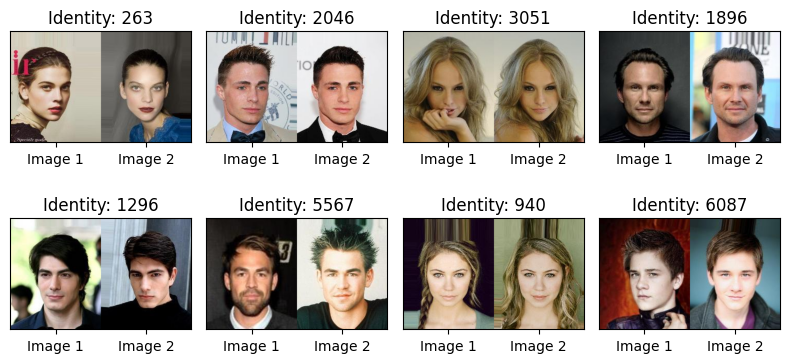

In [ ]:
displayValidate(selectedIdentities, n)

In [ ]:
finalize, datasetReport = writeSelectedImgSeries(4, 'solid-4', selectedIdentities)
print(f'There are {len(datasetReport)} identities listed.')
display(datasetReport)

There are 3018 identities listed.


,Identity,Frequency
0,8,4
1,12,4
2,13,4
3,14,4
4,15,4
...,...,...
3013,10163,4
3014,10167,4
3015,10174,4
3016,10175,4


In [ ]:
notTetra = datasetReport[datasetReport['Frequency'] < 4]
print(f'There are {len(notTetra)} identities that do not fulfill \n\
the requirement (failed to detect the face). Hence, total accepted are \
{len(datasetReport) - len(notTetra)} identities\n\
({(len(datasetReport) - len(notTetra)) * 4} images)')
display(notTetra)

There are 84 identities that do not fulfill 
the requirement (failed to detect the face). Hence, total accepted are 2934 identities
(11736 images)


,Identity,Frequency
113,338,1
141,415,3
159,458,3
160,459,1
200,589,0
...,...,...
2958,10023,1
2963,10033,2
2971,10055,1
2975,10062,1


In [ ]:
finalize()

Copying file://stage1-dir/celeba-selected-solid-4.zip [Content-Type=application/zip]...
/ [1/1 files][ 77.9 MiB/ 77.9 MiB] 100% Done                                    
Operation completed over 1 objects/77.9 MiB.                                     
Copying file://stage1-dir/celeba-selected-solid-4.json [Content-Type=application/json]...
\
Operation completed over 1 objects/7.3 MiB.                                      


1

#### Step 4: To create pairs in the dataset

In [ ]:
!gsutil -m cp gs://count-dracula/selected-dataset/celeba-selected-solid-4.json $__stage1_dir
!gsutil -m cp gs://count-dracula/selected-dataset/celeba-selected-solid-4.zip $__stage1_dir
with ZipFile(f'{__stage1_dir}/celeba-selected-solid-4.zip', 'r') as zipObj:
    zipObj.extractall(path=f"{__stage1_dir}/celeba-selected-solid-4")

Copying gs://count-dracula/selected-dataset/celeba-selected-solid-4.json...
\ [1/1 files][  7.3 MiB/  7.3 MiB] 100% Done                                    
Operation completed over 1 objects/7.3 MiB.                                      
Copying gs://count-dracula/selected-dataset/celeba-selected-solid-4.zip...
\ [1/1 files][ 77.9 MiB/ 77.9 MiB] 100% Done                                    
Operation completed over 1 objects/77.9 MiB.                                     


In [ ]:
x = {'a': 0}
x.update({'a': {'x': [1,2]}})
x.update({'a': {'d': 7}})
print(x)

{'a': {'d': 7}}


In [ ]:
def writePairedImages(__preVersionName, __versionName):
  __images = os.listdir(f'{__stage1_dir}/{__preVersionName}')
  __identity = list(set([i.split('-')[0] for i in __images]))
  __identity = list(np.random.choice(__identity, (2, len(__identity))))
  with open(f'{__stage1_dir}/{__preVersionName}.json') as f:
    __jsonData = json.load(f)
  __newJsonData = {}

  pairs = [
    [f'{i}-0', f'{i}-1'] for i in __identity[0]
  ]
  antiPairs = [
    [f'{i}-0', f'{__identity[0][j]}-3'] for j, i in enumerate(__identity[1])
  ]

  try:
    try:
      shutil.rmtree(f'{__stage1_dir}/{__versionName}')
    except:
      pass
    os.mkdir(f'{__stage1_dir}/{__versionName}')
  except:
    pass

  for k, i in enumerate(pairs):
    for j in range(0, 2):
      shutil.copy2(
        f'{__stage1_dir}/{__preVersionName}/{i[j]}.jpg',
        f'{__stage1_dir}/{__versionName}/pair-{k}-{j}.jpg'
      )
      __newJsonData.update({
        f'pair-{k}-{j}': {
          'p': __jsonData[f'{i[j]}'],
          'd': 1
        }
      })

  for k, i in enumerate(antiPairs):
    for j in range(0, 2):
      shutil.copy2(
        f'{__stage1_dir}/{__preVersionName}/{i[j]}.jpg',
        f'{__stage1_dir}/{__versionName}/antipair-{k}-{j}.jpg'
      )
      __newJsonData.update({
        f'antipair-{k}-{j}': {
          'p': __jsonData[f'{i[j]}'],
          'd': 0
        }
      })


  def finalize():
    with open(f'{__stage1_dir}/{__versionName}.json', 'w') as f:
      json.dump(__newJsonData, f)
    shutil.make_archive(
      f'{__stage1_dir}/{__versionName}',
      'zip',
      f'{__stage1_dir}/{__versionName}'
    )
    __zipDir = f'{__stage1_dir}/{__versionName}.zip'
    __jsnDir = f'{__stage1_dir}/{__versionName}.json'
    !gsutil -m cp $__zipDir "gs://count-dracula/selected-dataset"
    !gsutil -m cp $__jsnDir "gs://count-dracula/selected-dataset"

  def displayValidate2(__nImages):
    __imageSizeX = 178
    __pairType = [
        np.random.choice([i for i in range(0, x)], __nImages)
        for x in [len(pairs), len(antiPairs)]
      ]
    __dispName = ['pair', 'antipair']
    for p in range(0, 2):
      f, ax = plt.subplots(nrows=__nImages, figsize=(12, 10))
      for k, i in enumerate(__pairType[p]):
        ax[k].imshow(
          tf.concat([
            tf.keras.utils.img_to_array(
              tf.keras.utils.load_img(
                f'{__stage1_dir}/{__versionName}/{__dispName[p]}-{k}-{j}.jpg'
              )
            ) / 255.0
          for j in range(0, 2)], axis=1)
        )
        ax[k].set_title(f'{__dispName[p]} #{k}')

        xs = [
          [i + __imageSizeX * j
           for i in __newJsonData[f'{__dispName[p]}-{k}-{j}']['p']['x']]
        for j in range(0, 2)]
        ys = [
          [i  for i in __newJsonData[f'{__dispName[p]}-{k}-{j}']['p']['y']]
        for j in range(0, 2)]
        ax[k].scatter(xs[0], ys[0], s=0.7, c='red')
        ax[k].scatter(xs[1], ys[1], s=0.7, c='red')
        ax[k].get_yaxis().set_visible(False)
        ax[k].get_xaxis().set_visible(False)

  return finalize, displayValidate2


In [ ]:
finalize, displayValidate2 = writePairedImages(
  'celeba-selected-solid-4',
  'celeba-selected-paired-v0'
)

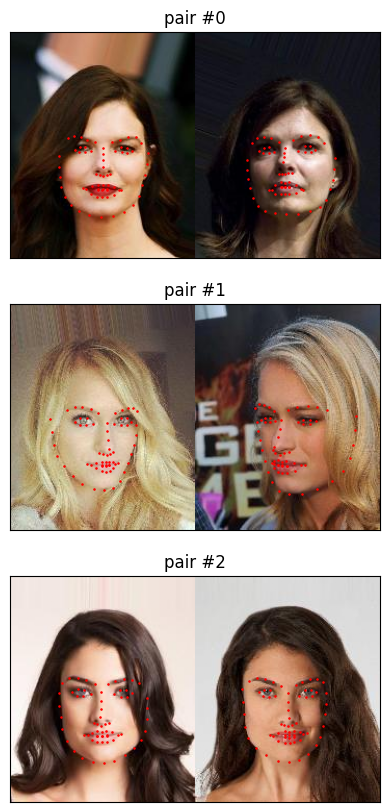

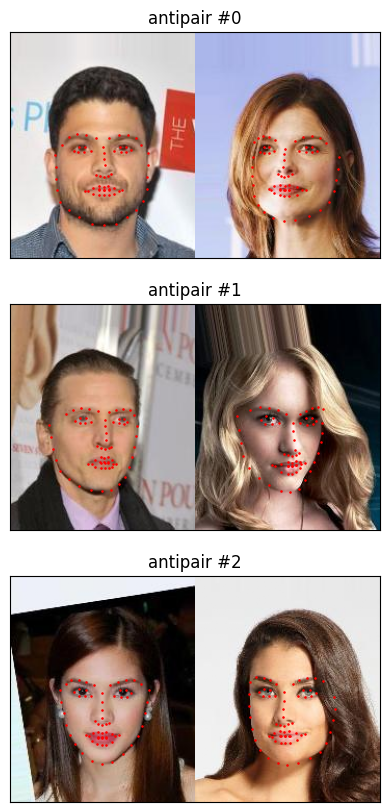

In [ ]:
displayValidate2(3)

In [ ]:
finalize()

Copying file://stage1-dir/celeba-selected-paired-v0.zip [Content-Type=application/zip]...
/ [1/1 files][ 77.8 MiB/ 77.8 MiB] 100% Done                                    
Operation completed over 1 objects/77.8 MiB.                                     
Copying file://stage1-dir/celeba-selected-paired-v0.json [Content-Type=application/json]...
-
Operation completed over 1 objects/7.6 MiB.                                      


# <font color=red> DEPRECATED. Section 4: Loading The First Stage Preprocessed Data

(goto Legacy - MLOps 2.ipynb instead)

CELL 4.0 | We prepare the directory for the dataset to be placed in.

In [ ]:
__stage2_dir = 'stage2-dir'
__versionName = 'celeba-selected-paired-v0'
!rm -rf $__stage2_dir
try:
  os.mkdir(__stage2_dir)
except:
  pass

CELL 4.1 | We download the already-preprocessed dataset from the Cloud Storage.

In [ ]:
__zipFile = f'gs://count-dracula/selected-dataset/{__versionName}.zip'
__jsnFile = f'gs://count-dracula/selected-dataset/{__versionName}.json'
!gsutil -m cp $__zipFile $__stage2_dir
!gsutil -m cp $__jsnFile $__stage2_dir
shutil.unpack_archive(
  f'{__stage2_dir}/{__versionName}.zip',
  f'{__stage2_dir}/{__versionName}',
  'zip'
)

Copying gs://count-dracula/selected-dataset/celeba-selected-paired-v0.zip...
- [1/1 files][ 77.8 MiB/ 77.8 MiB] 100% Done                                    
Operation completed over 1 objects/77.8 MiB.                                     
Copying gs://count-dracula/selected-dataset/celeba-selected-paired-v0.json...
/ [1/1 files][  7.6 MiB/  7.6 MiB] 100% Done                                    
Operation completed over 1 objects/7.6 MiB.                                      


CELL 4.2 | We load all of the images into the tensor. Instead of loading them all, we want to make sure the images loaded to the tensors are efficient, meaning that it loads when it is required. Hence, file naming is extremely crucial here to maintain the integrated structure.

In [ ]:
__features = tf.keras.utils.image_dataset_from_directory(
  directory = f'{__stage2_dir}',
  image_size = (218, 178),
  label_mode = None,
  color_mode = 'grayscale',
  shuffle = False,
  batch_size = 2
)

__paths = [i.split('/')[-1].split('.')[0] for i in __features.file_paths]

with open(f'{__stage2_dir}/{__versionName}.json', 'r') as f:
  __jsonLabels = json.load(f)

__targets = []

for i in __paths:
  __targets.append(
    __jsonLabels[i]['p']['x'] + __jsonLabels[i]['p']['y'] + [__jsonLabels[i]['d']]
  )

__targets = tf.data.Dataset.from_tensor_slices(tf.constant(__targets)).batch(2)


Found 11736 files belonging to 1 classes.


CELL 4.3 | Now that we have ```__features``` and ```__targets``` being paired, we can split the ```__features``` into two distinct tensors. Each of these tensors represents the complement image of the other image. In one fell swoop, we also split ```__targets__``` into three parts where the first two parts hold the landmarks of the pertaining images and the last part holds the similarity score. All of these can be done using a map dataset. The mapped dataset then can be zipped together, creating a zip dataset and each of the zipped datasets is zipped together again, creating a singular zip dataset ready to train.

In [ ]:
__features0 = __features.map(lambda x: x[0])
__features1 = __features.map(lambda x: x[1])
__targets0 = __targets.map(lambda x: tf.cast(x[0,:-1], tf.float32) / 218.0)
__targets1 = __targets.map(lambda x: tf.cast(x[1,:-1], tf.float32) / 218.0)
__targetsD = __targets.map(lambda x: tf.cast(x[0, -1], tf.float32))
allX = tf.data.Dataset.zip(__features0, __features1)
allY = tf.data.Dataset.zip(__targets0, __targets1, __targetsD)
allDs = tf.data.Dataset.zip(allX, allY).shuffle(64).batch(32)

DO NOT RUN THIS. SKIP OVER.

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


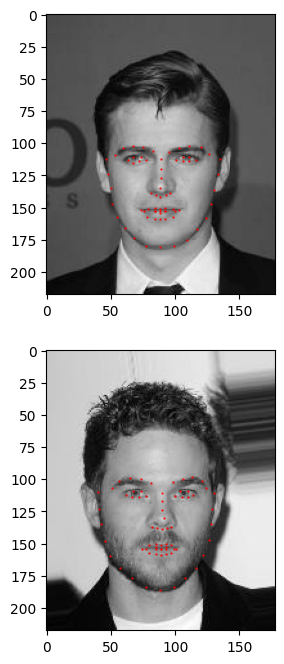

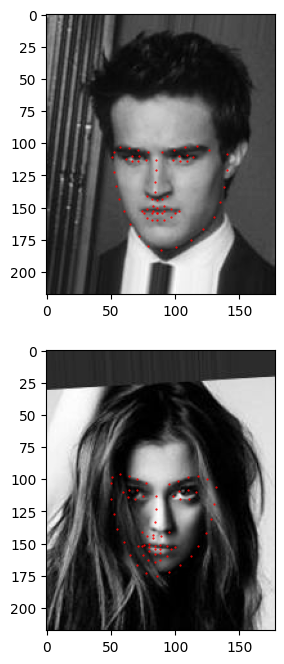

In [ ]:
# DO NOT RERUN THIS CELL. SKIP THIS OVER!
z = tf.data.Dataset.zip(__features0, __features1, __targets0, __targets1, __targetsD).shuffle(300)
for i in z.take(2):
  f, ax = plt.subplots(2, figsize=(10,8))
  ax[0].imshow(i[0], cmap='gray')
  ax[0].scatter(i[2][:68], i[2][68:], s=0.3, c='red')
  ax[1].imshow(i[1], cmap='gray')
  ax[1].scatter(i[3][:68], i[3][68:], s=0.3, c='red')
  print(i[4])

CELL 4.4 | We define the customized loss functions, namely ```Loss2```, ```Loss1```, and ```Loss0```, lambda functions, activation functions, and customized layer, namely ```NormedDense```.

Each of the loss functions performs different task. (Will not delve into mathematics at the moment).

In [ ]:
tf.random.set_seed(6969)
@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="Loss2"
)
class Loss2(tf.keras.losses.Loss):
  def __init__(self, delta=1):
    super().__init__()
    self.delta = delta

  def call (self, y_true, y_pred):
    a2 = y_true * tf.math.square(y_pred) #? x 1
    b2 = (1 - y_true) * tf.math.square(
        tf.math.maximum(self.delta - y_pred, 0)
    )
    c2 = a2 + b2
    return c2

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="Loss1"
)
class Loss1(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()

  def call (self, y_true, y_pred):
    a1 = y_true # ? x 136
    b1 = y_pred # ? x 136
    c1 = tf.math.sqrt(
      tf.math.reduce_sum(
        tf.math.square(a1 - b1),
        axis = -1,
        keepdims = True),
    )
    return c1

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="Loss0"
)
class Loss0(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()

  def call (self, y_true, y_pred):
    a0 = y_true # ? x 136
    b0 = y_pred # ? x 136
    c0 = tf.math.sqrt(
      tf.math.reduce_sum(
        tf.math.square(a0 - b0),
        axis = -1,
        keepdims = True),
    )
    return c0

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="angularDist"
)
def angularDist(vects):
  r0, r1 = vects
  dotProduct = tf.math.reduce_sum(r0 * r1, axis=-1)
  lengthR0 = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(r0), axis=-1))
  lengthR1 = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(r1), axis=-1))
  return tf.math.acos(dotProduct/(lengthR0 * lengthR1))

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="lambdaNormalizer"
)
def lambdaNormalizer(max=1, min=-1):
  def do(x):
    return x / 218
  return do

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="NormedDense"
)
class NormedDense(tf.keras.layers.Layer):
  def __init__(self, units=32, **kwargs):
    super(NormedDense, self).__init__(**kwargs)
    self.units = units

  def build(self, input_shape):
    __init_w = tf.random_normal_initializer()
    __init_b = tf.zeros_initializer()

    self.w = tf.Variable(
      name = 'weights',
      initial_value = __init_w(
        shape = (input_shape[-1], self.units),
        dtype = 'float32'
      ),
      trainable = True
    )
    self.b = tf.Variable(
      name = 'bias',
      initial_value = __init_b(
        shape = (self.units,),
        dtype='float32'
      ),
      trainable = True
    )

  def call(self, inputs):
    matrix = tf.linalg.matmul(inputs, self.w)
    maxPerFeatures = tf.math.reduce_max(matrix, axis=0, keepdims=True)
    minPerFeatures = tf.math.reduce_min(matrix, axis=0, keepdims=True)
    difPerFeatures = maxPerFeatures - minPerFeatures
    normedMatrix = (matrix - minPerFeatures) / difPerFeatures
    finalMatrix = normedMatrix + self.b
    return finalMatrix

CELL 4.5 | We create the customized Siamese Model with two inputs and three outputs. You can change the highlighted values to do the tuning.

In [ ]:
def basicCNNDraw(__Conv2DFilters, __prev):
  for k, i in enumerate(__Conv2DFilters):
    if (k == 0):
      __lyr = tf.keras.layers.Conv2D(i, (3,3))(__prev)
      __lyr = tf.keras.layers.MaxPooling2D((2,2))(__lyr)
      continue
    __lyr = tf.keras.layers.Conv2D(i, (3,3))(__lyr)
    __lyr = tf.keras.layers.MaxPooling2D((2,2))(__lyr)
  return __lyr

def basicDenseDraw(__units, __activation, __prev):
  for k, i in enumerate(__units):
    if (k == 0):
      __lyr = tf.keras.layers.Dense(i, activation=__activation[k])(__prev)
      continue
    __lyr = tf.keras.layers.Dense(i, activation=__activation[k])(__lyr)
  return __lyr

def head():
  __inp = tf.keras.layers.Input(shape=((218, 178) + (1, )))
  __lyr = basicCNNDraw(
    [128, 256, 64, 32],                                                           #YOU CAN CHANGE THIS
    __inp
  )
  __lyr = tf.keras.layers.Flatten()(__lyr)
  return tf.keras.models.Model(inputs=[__inp], outputs=[__lyr])

def neck(__shape):
  __inp = tf.keras.layers.Input(shape=__shape)
  __lyr = basicDenseDraw(
    [512, 221, 136],                                                              #YOU CAN CHANGE THIS
    ['relu', 'relu', 'relu'],                                                     #YOU CAN CHANGE THIS
    __inp
  )
  return tf.keras.models.Model(inputs=[__inp], outputs=[__lyr])

def tail(__shape):
  __inp = tf.keras.layers.Input(shape=__shape)
  __lyr = basicDenseDraw(
    [120, 32, 64],                                                                #YOU CAN CHANGE THIS
    ['relu', 'relu', 'relu'],                                                     #YOU CAN CHANGE THIS
    __inp
    )
  return tf.keras.models.Model(inputs=[__inp], outputs=[__lyr])

def body():
  inp0 = tf.keras.layers.Input(shape=(218, 178, 1))
  inp1 = tf.keras.layers.Input(shape=(218, 178, 1))

  headMdl = head()
  aux0 = headMdl(inp0)
  aux1 = headMdl(inp1)

  neckMdl = neck(aux0.shape)
  auxNeck0 = neckMdl(aux0)
  auxNeck1 = neckMdl(aux1)
  landmarks0 = NormedDense(136, name='L0')(auxNeck0)                              #YOU CAN ADD YOUR OWN SEQUENTIAL HERE
  landmarks1 = NormedDense(136, name='L1')(auxNeck1)                              #YOU CAN ADD YOUR OWN SEQUENTIAL HERE

  tailMdl = tail(auxNeck0.shape)
  aux0 = tailMdl(auxNeck0)
  aux1 = tailMdl(auxNeck1)

  lmdb = tf.keras.layers.Lambda(angularDist)([aux0, aux1])
  return tf.keras.models.Model(inputs=[inp0, inp1], outputs=[landmarks0, landmarks1, lmdb])


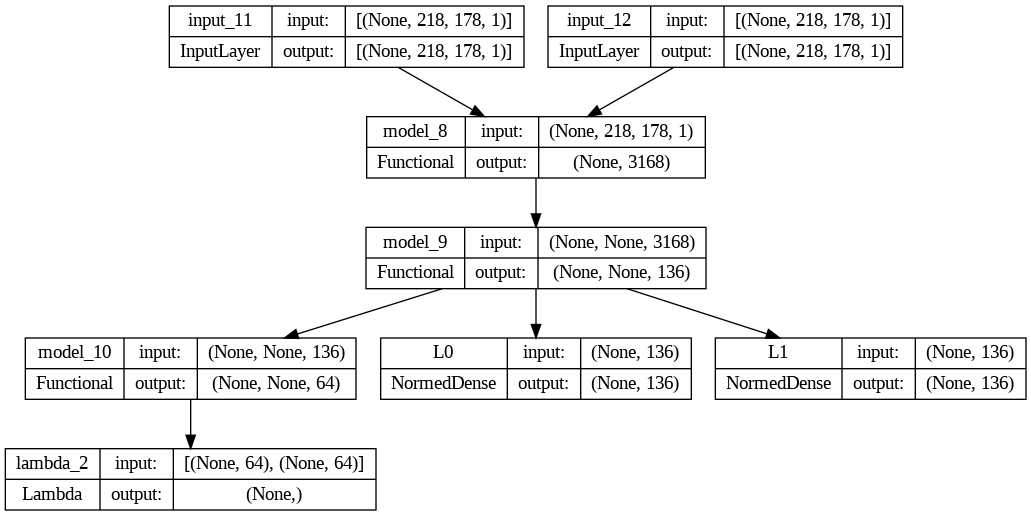

In [ ]:
mdl = body()
tf.keras.utils.plot_model(mdl, to_file='resqhub-ml-model.png', show_shapes=True)

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-6)
)

hist = mdl.fit(
    x = allDs,
    epochs=6
)

Epoch 1/6
184/184 [==============================] - 60s 256ms/step - loss: 7.0503 - L0_loss: 3.3828 - L1_loss: 3.4027 - lambda_loss: 0.2648
Epoch 2/6
184/184 [==============================] - 47s 257ms/step - loss: 6.9304 - L0_loss: 3.3220 - L1_loss: 3.3514 - lambda_loss: 0.2570
Epoch 3/6
184/184 [==============================] - 46s 248ms/step - loss: 6.8479 - L0_loss: 3.2814 - L1_loss: 3.3147 - lambda_loss: 0.2517
Epoch 4/6
184/184 [==============================] - 48s 258ms/step - loss: 6.7960 - L0_loss: 3.2518 - L1_loss: 3.2930 - lambda_loss: 0.2512
Epoch 5/6
184/184 [==============================] - 47s 252ms/step - loss: 6.7353 - L0_loss: 3.2217 - L1_loss: 3.2659 - lambda_loss: 0.2476
Epoch 6/6
184/184 [==============================] - 47s 255ms/step - loss: 6.6812 - L0_loss: 3.1979 - L1_loss: 3.2366 - lambda_loss: 0.2468


CELL 4.6 | Make sure you create a checkpoint.

In [ ]:
mdl.save('model-checkpoint-1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
history = hist.history
with open('history-checkpoint-1.json', 'w') as f:
  json.dump(history, f)